In [1]:
from Question1 import *
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from lightgbm.sklearn import LGBMRanker
from scipy.sparse import csr_matrix

In [2]:
BASE_PATH = '../Data/'
transactions = pd.read_parquet(BASE_PATH + 'transactions_train.parquet')
customers = pd.read_parquet(BASE_PATH + 'customers.parquet')
articles = pd.read_parquet(BASE_PATH + 'articles.parquet')
sample_submission = pd.read_csv(BASE_PATH + 'sample_submission.csv')

In [3]:
# Candidate generation of Radek notebook
def get_data(data, test_week):
    ### repurchase
    # each week is seen as a basket
    # the items bought in one basket, will be example for the next basket
    # the items bought in the last basket, will be candidates for the test basket
    candidates_last_purchase = data.copy()
    c2weeks = data.groupby('customer_id')['week'].unique()
    
    c2weeks2shifted_weeks = {}
    for c_id, weeks in c2weeks.items():
        shifted_weeks = weeks[1:].tolist() + [test_week]
        c2weeks2shifted_weeks[c_id] = dict(zip(weeks, shifted_weeks))

    candidates_last_purchase['week'] = [
        c2weeks2shifted_weeks[c_id][week]
        for c_id, week in zip(data['customer_id'], data['week'])
    ]

    ### bestseller
    # if a user bought an item in a given week, the 12 most popular items in the previous week are example for that week
    # the best selling items in the last week are candidates for all users
    mean_price = data \
        .groupby(['week', 'article_id'])['price'].mean()
    sales = data \
        .groupby('week')['article_id'].value_counts() \
        .groupby('week').rank(method='dense', ascending=False) \
        .groupby('week').head(12).rename('bestseller_rank').astype('int8')
    bestsellers_previous_week = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()
    bestsellers_previous_week.week += 1
    unique_transactions = data \
        .groupby(['week', 'customer_id']) \
        .head(1) \
        .drop(columns=['article_id', 'price']) \
        .copy()
    candidates_bestsellers = pd.merge(
        unique_transactions,
        bestsellers_previous_week,
        on='week',
    )
    test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
    test_set_transactions.week = test_week
    candidates_bestsellers_test_week = pd.merge(
        test_set_transactions,
        bestsellers_previous_week,
        on='week'
    )
    candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
    candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)

    ### combine
    d = data.copy()
    d['purchased'] = True
    
    result = pd.concat([
        d, candidates_last_purchase, candidates_bestsellers
    ])
    result.purchased.fillna(False, inplace=True)
    result.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

    result = pd.merge(
        result,
        bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
        on=['week', 'article_id'],
        how='left'
    )
    result = result[result.week != result.week.min()]
    result.bestseller_rank.fillna(999, inplace=True)

    result.sort_values(['week', 'customer_id'], inplace=True)
    result.reset_index(drop=True, inplace=True)
    return result

def get_examples(data, test_week):
    data = get_data(data, test_week)
    return data[data.week != test_week]

def get_candidates(data, test_week):
    data = get_data(data, test_week)
    return data[data.week == test_week]

def add_features(data, columns_to_use = None):
    if not columns_to_use:
        columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id','perceived_colour_master_id', 'department_no', 'index_code','index_group_no', 'section_no', 'garment_group_no','score','price'
        ]

    result = data
    result = pd.merge(result, customers, how='left', on='customer_id')
    result = pd.merge(result, articles, how='left', on='article_id')

    result['score'] = result.apply(get_score,axis=1).fillna(0)
    
    return result[columns_to_use]

def get_score(entry):
    """Method that returns the user-item score given a dataframe row containing columns [customer_id,article_id]"""
    try:
        return ui_score.loc[entry['customer_id'], entry['article_id']]
    except KeyError:
        return None

def recall(predictions, purchases, k=12):
    def calculate_recall(row):
        intersect_count = len(set(row['prediction'][:k]).intersection(row['purchases']))
        return intersect_count / min(len(row['purchases']), k) if len(row['purchases']) > 0 else 0

    result = pd.merge(purchases, predictions, on="customer_id", how="inner")
    result['recall'] = result.apply(calculate_recall, axis=1)

    return result['recall'].mean()

In [4]:
def get_sim(recmodel,purchase_sparse):
    """Method to get the dot product of an item similarity matrix with the articles frequency of every user"""
    s2 = cosine_similarity(recmodel.articles_latent_matrix, recmodel.articles_latent_matrix)
    return purchase_sparse.dot(s2)

def apply_filter(scores, filter_matrix):
    """Method to apply the filter that prunes already purchased articles for every user. It's done in chunks to be less RAM heavy"""
    chunk_size = 10000
    num_rows, num_cols = scores.shape
    result = np.zeros((num_rows, num_cols))
    
    for i in range(0, num_rows, chunk_size):
        chunk_end = min(i + chunk_size, num_rows)
        ui_chunk = scores.iloc[i:chunk_end].values
        filter_chunk = filter_matrix[i:chunk_end]
        result[i:chunk_end] = np.multiply(ui_chunk, filter_chunk)
    
    return pd.DataFrame(result, index=scores.index, columns=scores.columns)


def get_useritem_data(recmodel):
    """Method that returns the user-item interaction matrix with scores"""
    itemcf_transactions['article_id'] = itemcf_transactions['article_id'].astype(int)
    purchase_counts = itemcf_transactions.groupby(['customer_id', 'article_id']).size().rename('count').reset_index().sort_values('article_id') # article frequency matrix 
    
    user_to_index = {user_id: index for index, user_id in enumerate(purchase_counts['customer_id'].unique())}
    article_to_index = {article_id: index for index, article_id in enumerate(purchase_counts['article_id'].unique())}
    
    row_indices = purchase_counts['customer_id'].map(user_to_index).values
    col_indices = purchase_counts['article_id'].map(article_to_index).values
    spdata = purchase_counts['count'].values
    
    # sparse matrix to preserve RAM
    purchase_counts_sparse = csr_matrix((spdata, (row_indices, col_indices)), shape=(len(user_to_index), len(article_to_index)), dtype=int)
    
    # dataframe of the user-item matrix
    result = pd.DataFrame(get_sim(recmodel,purchase_counts_sparse), index=user_to_index.keys(), columns=article_to_index.keys())
    
    # create a matrix containing 1's for items not bought by the user and 0 for item's that were already purchased
    purchase_counts_sparse = csr_matrix((np.ones_like(spdata), (row_indices, col_indices)), shape=(len(user_to_index), len(article_to_index)), dtype=int).toarray()
    filter_matrix = 1 - purchase_counts_sparse
    del purchase_counts
    
    return apply_filter(result,filter_matrix)

In [5]:
### split into training and testing
# one week is used for testing
# a number of weeks leading up to the test week are used to train the ranker
test_week = 104
num_training_weeks = 10
testing_weeks = np.arange(test_week-num_training_weeks, test_week)
train_data = transactions[transactions.week.isin(testing_weeks)].reset_index(drop=True)

## CF preprocessing
We take only the articles bought more than 10 times in the training weeks

In [6]:
itemcf_transactions = train_data.copy().drop(['sales_channel_id', 'price', 'week'], axis=1)
most_bought_articles = itemcf_transactions['article_id'].value_counts()[lambda x: x > 10].index
itemcf_transactions = itemcf_transactions[itemcf_transactions['article_id'].isin(most_bought_articles)]
itemcf_transactions['purchased'] = 1
itemcf_transactions

,t_dat,customer_id,article_id,purchased
0,2020-07-08,857913002275398,599580068,1
1,2020-07-08,857913002275398,776237011,1
2,2020-07-08,857913002275398,844294001,1
3,2020-07-08,1658289241058394,877773001,1
4,2020-07-08,3828854365940846,507883009,1
...,...,...,...,...
2809228,2020-09-15,18446630855572834764,568601045,1
2809229,2020-09-15,18446630855572834764,568601045,1
2809230,2020-09-15,18446630855572834764,898713001,1
2809231,2020-09-15,18446630855572834764,898713001,1


### Generate negative candidates

In [7]:
np.random.seed(42)
negative_samples = pd.DataFrame({
    'article_id': np.random.choice(itemcf_transactions.article_id.unique(), itemcf_transactions.shape[0]),
    'customer_id': np.random.choice(itemcf_transactions.customer_id.unique(), itemcf_transactions.shape[0]),
    'purchased': np.zeros(itemcf_transactions.shape[0])
})
negative_samples

,article_id,customer_id,purchased
0,736114004,18086686802776796719,0.0
1,740927007,4461276169114434759,0.0
2,887374002,10835517453566354608,0.0
3,890855004,15020323395942642257,0.0
4,756320023,14717588240017532030,0.0
...,...,...,...
2745304,916823001,6885894605806142682,0.0
2745305,846334002,13792438975120382134,0.0
2745306,407354004,6721478277661818867,0.0
2745307,750422023,10836663088955469328,0.0


### Train CF model using SGD algorithm

Epoch: 0


100%|██████████| 5490618/5490618 [01:09<00:00, 79241.12it/s]


Epoch: 1


100%|██████████| 5490618/5490618 [01:10<00:00, 78101.27it/s]


Epoch: 2


100%|██████████| 5490618/5490618 [01:10<00:00, 78412.97it/s]


Epoch: 3


100%|██████████| 5490618/5490618 [01:10<00:00, 77918.81it/s]


Epoch: 4


100%|██████████| 5490618/5490618 [01:10<00:00, 78202.19it/s]


Epoch: 5


100%|██████████| 5490618/5490618 [01:10<00:00, 77951.69it/s]


Epoch: 6


100%|██████████| 5490618/5490618 [01:10<00:00, 78105.71it/s]


Epoch: 7


100%|██████████| 5490618/5490618 [01:10<00:00, 77955.39it/s]


Epoch: 8


100%|██████████| 5490618/5490618 [01:10<00:00, 77762.51it/s]


Epoch: 9


100%|██████████| 5490618/5490618 [01:10<00:00, 77818.25it/s]


Epoch: 10


100%|██████████| 5490618/5490618 [01:10<00:00, 77657.82it/s]


Epoch: 11


100%|██████████| 5490618/5490618 [01:10<00:00, 77887.99it/s]


Epoch: 12


100%|██████████| 5490618/5490618 [01:10<00:00, 77592.63it/s]


Epoch: 13


100%|██████████| 5490618/5490618 [01:10<00:00, 77786.33it/s]


Epoch: 14


100%|██████████| 5490618/5490618 [01:10<00:00, 77632.74it/s]


Epoch: 15


100%|██████████| 5490618/5490618 [01:10<00:00, 77775.97it/s]


Epoch: 16


100%|██████████| 5490618/5490618 [01:10<00:00, 77629.11it/s]


Epoch: 17


100%|██████████| 5490618/5490618 [01:10<00:00, 77754.02it/s]


Epoch: 18


100%|██████████| 5490618/5490618 [01:11<00:00, 77312.08it/s]


Epoch: 19


100%|██████████| 5490618/5490618 [01:11<00:00, 76456.78it/s]


Epoch: 20


100%|██████████| 5490618/5490618 [01:10<00:00, 77501.35it/s]


Epoch: 21


100%|██████████| 5490618/5490618 [01:11<00:00, 76533.16it/s]


Epoch: 22


100%|██████████| 5490618/5490618 [01:11<00:00, 76514.98it/s]


Epoch: 23


100%|██████████| 5490618/5490618 [01:12<00:00, 76130.30it/s]


Epoch: 24


100%|██████████| 5490618/5490618 [01:12<00:00, 76230.87it/s]


Epoch: 25


100%|██████████| 5490618/5490618 [01:11<00:00, 76397.60it/s]


Epoch: 26


100%|██████████| 5490618/5490618 [01:12<00:00, 75987.64it/s]


Epoch: 27


100%|██████████| 5490618/5490618 [01:12<00:00, 76058.42it/s]


Epoch: 28


100%|██████████| 5490618/5490618 [01:11<00:00, 76313.99it/s]


Epoch: 29


100%|██████████| 5490618/5490618 [01:12<00:00, 75897.35it/s]


Epoch: 30


100%|██████████| 5490618/5490618 [01:12<00:00, 75908.46it/s]


Epoch: 31


100%|██████████| 5490618/5490618 [01:11<00:00, 76423.05it/s]


Epoch: 32


100%|██████████| 5490618/5490618 [01:11<00:00, 76375.32it/s]


Epoch: 33


100%|██████████| 5490618/5490618 [01:12<00:00, 75960.12it/s]


Epoch: 34


100%|██████████| 5490618/5490618 [01:12<00:00, 75419.44it/s]


Epoch: 35


100%|██████████| 5490618/5490618 [01:12<00:00, 76013.02it/s]


Epoch: 36


100%|██████████| 5490618/5490618 [01:12<00:00, 75900.26it/s]


Epoch: 37


100%|██████████| 5490618/5490618 [01:12<00:00, 75904.24it/s]


Epoch: 38


100%|██████████| 5490618/5490618 [01:12<00:00, 76018.02it/s]


Epoch: 39


100%|██████████| 5490618/5490618 [01:12<00:00, 75564.72it/s]


Epoch: 40


100%|██████████| 5490618/5490618 [01:11<00:00, 76341.49it/s]


Epoch: 41


100%|██████████| 5490618/5490618 [01:11<00:00, 76543.77it/s]


Epoch: 42


100%|██████████| 5490618/5490618 [01:11<00:00, 77021.51it/s]


Epoch: 43


100%|██████████| 5490618/5490618 [01:11<00:00, 76960.41it/s]


Epoch: 44


100%|██████████| 5490618/5490618 [01:10<00:00, 77387.22it/s]


Epoch: 45


100%|██████████| 5490618/5490618 [01:09<00:00, 78727.70it/s]


Epoch: 46


100%|██████████| 5490618/5490618 [01:08<00:00, 79856.78it/s]


Epoch: 47


100%|██████████| 5490618/5490618 [01:09<00:00, 79026.59it/s]


Epoch: 48


100%|██████████| 5490618/5490618 [01:10<00:00, 77664.39it/s]


Epoch: 49


100%|██████████| 5490618/5490618 [01:11<00:00, 77127.48it/s]


Epoch: 50


100%|██████████| 5490618/5490618 [01:10<00:00, 77350.17it/s]


Epoch: 51


100%|██████████| 5490618/5490618 [01:10<00:00, 78250.45it/s]


Epoch: 52


100%|██████████| 5490618/5490618 [01:10<00:00, 77974.93it/s]


Epoch: 53


100%|██████████| 5490618/5490618 [01:12<00:00, 75658.32it/s]


Epoch: 54


100%|██████████| 5490618/5490618 [01:09<00:00, 79234.35it/s]


Epoch: 55


100%|██████████| 5490618/5490618 [01:08<00:00, 79965.54it/s]


Epoch: 56


100%|██████████| 5490618/5490618 [01:08<00:00, 79832.40it/s]


Epoch: 57


100%|██████████| 5490618/5490618 [01:08<00:00, 80032.67it/s]


Epoch: 58


100%|██████████| 5490618/5490618 [01:08<00:00, 79989.15it/s]


Epoch: 59


100%|██████████| 5490618/5490618 [01:08<00:00, 80129.05it/s]


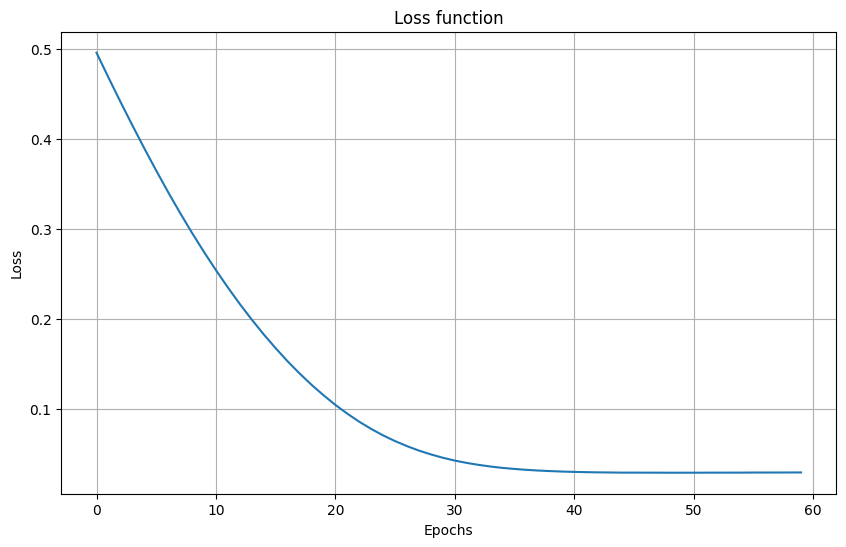

In [8]:
rec = ItemCF(itemcf_transactions, negative_samples, num_components=1000)
rec.fit(n_epochs=60)

Calculate the user-item interaction matrix by using the data from the CF model

In [9]:
%%time
ui_score = get_useritem_data(rec)

CPU times: total: 1min 19s
Wall time: 8min 38s


In [10]:
ui_score

,108775044,111565001,111586001,111593001,111609001,120129001,120129014,123173001,126589010,129085001,...,947168001,947509001,947934001,949198001,949551001,949551002,952267001,953450001,953763001,956217002
6326351327209594402,0.000000,0.104321,-0.065291,-0.138951,-0.219930,0.190701,0.233349,-0.172824,-0.395152,-0.133642,...,0.038388,-0.077964,-0.075219,0.106869,-0.268562,0.096398,-0.223786,-0.449740,-0.236870,0.429169
15078695326066239144,0.000000,0.017451,-0.006084,-0.017072,-0.118663,-0.028954,0.159464,-0.119626,-0.272191,-0.162605,...,-0.041264,0.222074,-0.114668,0.285866,0.032892,-0.209678,-0.140812,0.114078,-0.089296,-0.079415
18304370977760179130,0.000000,0.361349,-0.402717,0.347223,-0.222933,-0.016408,-0.387563,0.039925,-0.342284,-0.174316,...,-0.141820,0.021623,0.176766,0.106066,0.145338,0.015991,0.075193,-0.060601,-0.008286,0.069321
2189559865845641103,0.000000,0.199633,0.226457,-0.080535,0.105419,0.357149,0.090964,0.151722,-0.098358,-0.350014,...,0.159161,-0.245506,0.042885,0.228832,-0.048489,-0.055453,0.127514,0.002435,0.097392,0.204046
10926728289202456124,0.000000,-0.071517,-0.136886,-0.068440,0.017413,-0.046164,-0.134872,0.087310,-0.023954,-0.124198,...,-0.056648,0.060876,-0.032793,0.027334,-0.008436,-0.188249,-0.062609,-0.073615,0.165899,0.014485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958904871616586093,0.004041,0.129440,-0.150692,0.093338,-0.048813,0.058598,-0.061329,0.097079,0.048488,0.184477,...,0.163103,0.040855,0.000000,-0.034594,0.064956,-0.059883,-0.044554,-0.079825,0.043473,0.196912
4640197955788019288,0.018085,-0.003829,0.020696,-0.071786,0.006059,-0.047331,-0.001440,0.047474,-0.030284,0.062596,...,-0.005777,0.052651,0.021652,0.032845,0.000000,0.032927,0.038399,0.031856,0.008147,0.005194
10710816612315450049,0.018085,-0.003829,0.020696,-0.071786,0.006059,-0.047331,-0.001440,0.047474,-0.030284,0.062596,...,-0.005777,0.052651,0.021652,0.032845,0.000000,0.032927,0.038399,0.031856,0.008147,0.005194
9735950175229244303,0.018085,-0.003829,0.020696,-0.071786,0.006059,-0.047331,-0.001440,0.047474,-0.030284,0.062596,...,-0.005777,0.052651,0.021652,0.032845,0.000000,0.032927,0.038399,0.031856,0.008147,0.005194


In [11]:
### assemble training data (positive + negative examples)
# each example has at least a customer_id, article_id and whether it was purchased or not (positive/negative)
# add_features extracts and adds features to the examples
train_examples = get_examples(train_data, test_week)
X_train = add_features(train_examples)
Y_train = train_examples['purchased']

### fit ranker
# training_groups tells LGBM that each (week, customer_id) combination is a seperate basket
# !!! it is important that the training_examples are sorted according to week, customer_id for this to work
ranker = LGBMRanker(
    force_row_wise=True,
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)
train_groups = train_examples.groupby(['week', 'customer_id'])['article_id'].count().values
ranker.fit(X_train, Y_train, group=train_groups)
print_importance(ranker, X_train.columns)



[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.112795
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 11557594, number of used features: 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
                         score 0.99563
                         price 0.00319
                    article_id 0.00049
              garment_group_no 0.00028
                 department_no 0.00016
               product_type_no 0.00015
                    section_no 0.00006
             colour_group_code 0.00004
                index_group_no 0.00000
                    index_code 0.00000
    perceived_colour_master_id 0.00000
     perceived_colour_value_id 0.00000
       graphical_appearance_no 0.00000


In [12]:
%%time
### test
# candidates are generated similarly to the examples, only we don't know whether they are purchased
# the same features are extracted and added
# each candidate is scored by the ranker and predictions are generated using the highest scoring candidates
test_candidates = get_candidates(train_data, test_week)
X_test = add_features(test_candidates)
predictions = get_predictions(test_candidates, X_test, ranker, 12)

### evaluate
if test_week < transactions.week.max() + 1:
    # get ground truth data for test week
    purchases = get_purchases(transactions[transactions.week == test_week])
    
    # fill missing prediction for customers in test set with popular items in last week
    # only for customers in test set because only those are evaluated
    popular = transactions[transactions.week == test_week-1].article_id.value_counts().head(12).index.values
    predictions = fill_missing_predictions(predictions, purchases.customer_id, popular)
    
    # calculate score
    score = mean_average_precision(predictions, purchases, 12)
    print(score)

### submit
else:
    # fill missing predictions for all customers with popular items in last week
    # all customers because we don't know which ones will be evaluated
    popular = transactions[transactions.week == test_week-1].article_id.value_counts().head(12).index.values
    predictions = fill_missing_predictions(predictions, customers.customer_id, popular)

    # write submission
    sub = create_submission(predictions,sample_submission)
    sub.to_csv('output/' + 'sub1.csv.gz', index=False)

0.025965239693955543
CPU times: total: 17.2 s
Wall time: 3min 27s


In [13]:
recall(predictions,purchases,12)

0.05234812642001266

#### Evaluation:
 **MAP@12:** 0.02596
 **Recall@12:** 0.05234